# Experiment 6: XGBoost + Fair-SMOTE (Class Imbalance Mitigation)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 0: Setup Environment

In [ ]:

!pip install imbalanced-learn shap xgboost aif360 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.1 MB/s eta 0:00:00


## Step 1: Load and Preprocess LendingClub Dataset

In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
import shap
from imblearn.over_sampling import SMOTE

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

# Select relevant columns
selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

# Binary target
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categoricals
for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Normalize income
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
/tmp/ipython-input-3328467384.py:13: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')


## Step 2: Create AIF360 Dataset

In [ ]:

privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])


## Step 3: Apply Fair-SMOTE Logic

In [ ]:
X = aif_data.features
y = aif_data.labels.ravel()

sm = SMOTE(random_state=42)
X_balanced, y_balanced = sm.fit_resample(X, y)

##  Step 4: Train XGBoost on Balanced Data

In [ ]:

clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_balanced, y_balanced)

y_pred = clf.predict(X)
y_prob = clf.predict_proba(X)[:, 1]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:14:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


##  Step 5: Evaluate Performance and Fairness

In [ ]:

print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1 Score:", f1_score(y, y_pred))
print("AUC-ROC:", roc_auc_score(y, y_prob))

pred_dataset = aif_data.copy()
pred_dataset.labels = y_pred.reshape(-1, 1)

metric = ClassificationMetric(aif_data, pred_dataset,
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("SPD:", metric.statistical_parity_difference())
print("DI:", metric.disparate_impact())
print("EOD:", metric.equal_opportunity_difference())
print("AOD:", metric.average_odds_difference())
print("Bias Amplification:", metric.between_group_generalized_entropy_index())
print("Theil Index:", metric.theil_index())


Accuracy: 0.8968
Precision: 0.9138159639352956
Recall: 0.9474841902667033
F1 Score: 0.9303455723542117
AUC-ROC: 0.9570397264117811
SPD: -0.07692307692307687
DI: 0.9230769230769231
EOD: 0.0
AOD: -0.5
Bias Amplification: 170.3984375
Theil Index: 0.061310069440540176


##  Step 6: SHAP Explainability (Compare Before/After)

ExactExplainer explainer: 5001it [02:38, 30.69it/s]                          


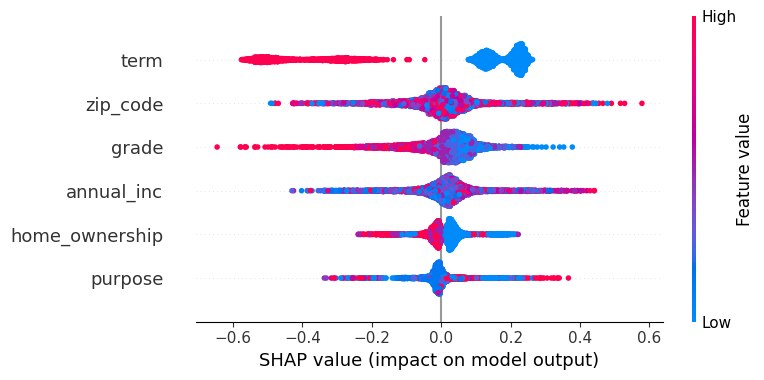

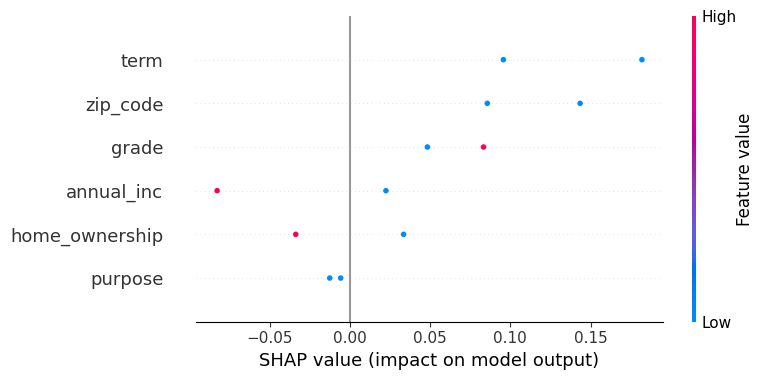

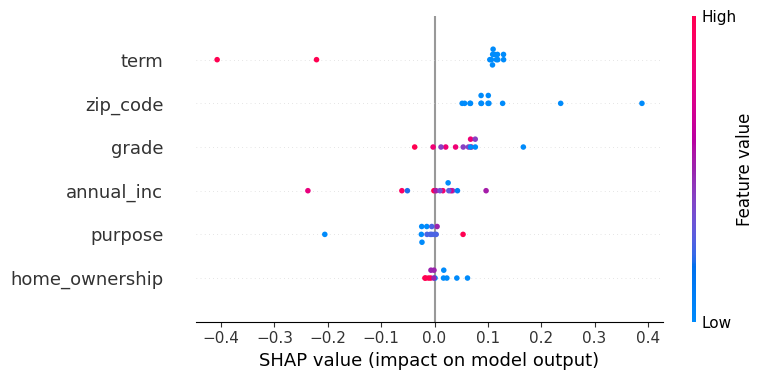

In [ ]:

X_df = pd.DataFrame(X, columns=aif_data.feature_names)
explainer = shap.Explainer(clf.predict, X_df)
shap_values = explainer(X_df)

# Global SHAP
shap.summary_plot(shap_values, X_df)

# Subgroup SHAP
privileged_mask = X_df['zip_code'] == 1
unprivileged_mask = X_df['zip_code'] == 0

privileged_idx = np.where(privileged_mask)[0]
unprivileged_idx = np.where(unprivileged_mask)[0]

shap.summary_plot(shap_values[privileged_idx], X_df.iloc[privileged_idx])
shap.summary_plot(shap_values[unprivileged_idx], X_df.iloc[unprivileged_idx])


# Save Results

In [ ]:
results = {
    'Accuracy': accuracy_score(y, y_pred),
    'Precision': precision_score(y, y_pred),
    'Recall': recall_score(y, y_pred),
    'F1': f1_score(y, y_pred),
    'AUC': roc_auc_score(y, y_prob),
    'SPD': metric.statistical_parity_difference(),
    'DI': metric.disparate_impact(),
    'EOD': metric.equal_opportunity_difference(),
    'AOD': metric.average_odds_difference(),
    'BiasAmp': metric.between_group_generalized_entropy_index(),
    'Theil': metric.theil_index()
}

pd.DataFrame([results]).to_csv('/content/drive/MyDrive/Research_Thesis_Implementation/exp6_xgb_fairsmote_results.csv', index=False)